In [766]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, GRO, XTC

import warnings
# suppress some MDAnalysis warnings about PSF files
#warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

import subprocess
import glob
import pandas as pd


General settings

Reading all results files

In [767]:
def generate_plots(name,run,resultsdir,dataframedir):

    ##### PARM file

    parmfile=resultsdir+name+'.parm7'

    ##### TRAJECTORY FILES

    #trajfile=resultsdir+run+name+'.nc'
    trajfiles = sorted(glob.glob(resultsdir+run+name+'_?.nc'))
    print('trajectory files:',trajfiles)

    ##### MDOUT files

    mdoutfiles = sorted(glob.glob(resultsdir+run+name+'_?.mdout'))
    print(mdoutfiles)
    pipe = subprocess.run(["process_mdout.perl"]+mdoutfiles,
                        check=True,
                        text=True,
                        capture_output=True)

In [768]:
    # some information
    u = mda.Universe(parmfile,trajfiles)
    protein = u.select_atoms("protein")
    print('Universe:',u)
    #print(hasattr(u, 'trajectory'))
    print('Trajectory of run {0} contains {1} steps'.format(run,len(u.trajectory)))
    #print(u.residues)
    #print(u.atoms)
    #print(u.select_atoms('resname TPQ').n_atoms)
    #print(u.atoms[:45].names)

/Users/jordivilla/miniconda3/lib/python3.12/site-packages/MDAnalysis/topology/TOPParser.py:306: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(msg)


Universe: <Universe with 174032 atoms>
Trajectory of run md contains 615 steps


In [769]:
    time = []
    rgyr = []
    for ts in u.trajectory:
        time.append(u.trajectory.time)
        rgyr.append(protein.radius_of_gyration())


now transform into a pandas dataframe and plot

In [770]:
    # rgyr_df = pd.DataFrame(time,rgyr, columns=['Radius of gyration (A)'], index=None)
    # rgyr_df.index.name = 'Time (ps)'



    rgyr_df = pd.DataFrame(list(zip(time, rgyr)),
                columns =['Time (ps)', 'Radius of gyration (A)'],
                index=None)
    rgyr_df.to_csv(dataframedir+name+'RG.csv',index=False)
    rgyr_df.head()
    rgyr_df.size

1230

Time (ps) Radius of gyration (A)


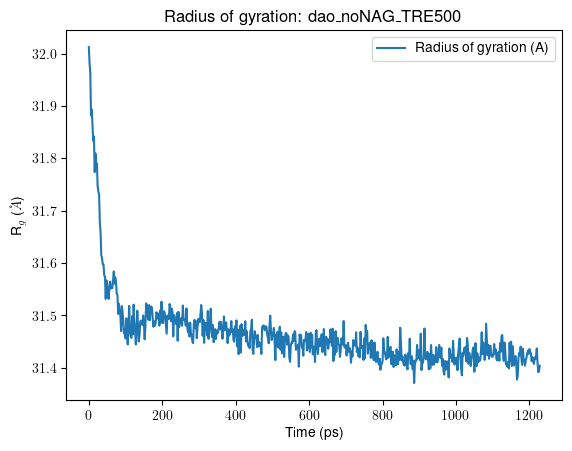

In [771]:


        x_name = rgyr_df.columns[0]
        y_name = rgyr_df.columns[1]
        print(x_name,y_name)
        x=rgyr_df[x_name]
        y=rgyr_df[y_name]

        # plt.title('Radius of gyration: '+name)
        # plt.plot(x,y)
        # plt.savefig('../text/figures/'+name+'RG.png')

        ax = rgyr_df.plot(title='Radius of gyration: '+name,x=x_name, y=y_name,kind='line')
        ax.set_ylabel(r'R$_g$ ($\AA$)')
        plt.savefig('../text/figures/'+name+'RG.png')


now run a complete RMSD plot

The resultsdir are stored in the `.rmsd` attribute. This is an array with the shape `(n_frames, 2 + n_selections)`.

In [772]:
    u.trajectory[0] # set to first frame
    rmsd_analysis = rms.RMSD(u, select='backbone')
    rmsd_analysis.run()
    rmsd_analysis.results.rmsd.shape
    print(rmsd_analysis.rmsd.shape)

    rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd,
                        columns=['Frame', 'Time (ps)', 'Backbone'])
    rmsd_df = rmsd_df[['Time (ps)', 'Backbone']]
    rmsd_df.to_csv(dataframedir+name+'RMSD.csv',index=False)
    rmsd_df.head()



(615, 3)


/Users/jordivilla/miniconda3/lib/python3.12/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


,Time (ps),Backbone
0,0.0,0.000003
1,2.0,0.532856
2,4.0,0.544003
3,6.0,0.596421
4,8.0,0.614963


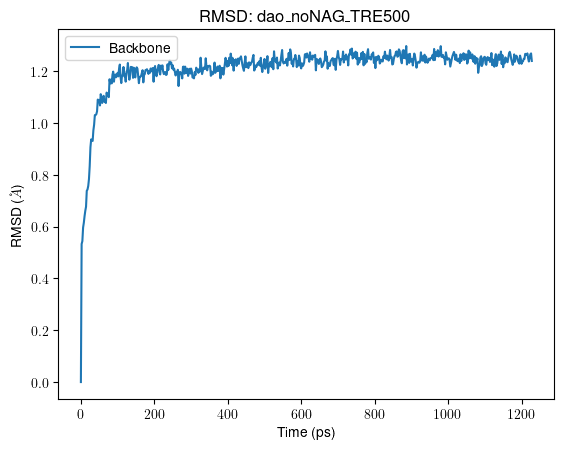

In [773]:
    ax = rmsd_df.plot(title='RMSD: '+name,x='Time (ps)', y=['Backbone'],kind='line')
    ax.set_ylabel(r'RMSD ($\AA$)')
    plt.savefig('../text/figures/'+name+'RMSD.png')

# Fast processing of output with `process_mdout.perl`

plot a collection of graphs to check the process of the calculation


<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/v5/vwzdch316vzcj9qldllr58800000gp/T/ipykernel_20068/3534115571.py:25: SyntaxWarning: invalid escape sequence '\s'
  temp_df = pd.read_csv("summary."+key,names=colnames,sep='\s+',index_col=None)


{'DENSITY': '$\\rho$', 'EKCMT': 'E_k CMT / kcal mol$^-1$', 'EKTOT': 'E_k / kcal mol$-1$', 'EPTOT': 'E_p / kcal mol$-1$', 'ESCF': 'ESCF', 'ETOT': 'E_tot / kcal mol$-1$', 'PRES': 'PRESS', 'TEMP': 'T / K', 'TSOLUTE': 'T / K', 'TSOLVENT': 'T / K'}
EKTOT E_k / kcal mol$-1$
   Time (ps)       EKTOT
0       20.2  90439.4412
1       20.4  90173.0812
2       20.6  90285.8333
3       20.8  90416.9375
4       21.0  90512.4445
EPTOT E_p / kcal mol$-1$
   Time (ps)        EPTOT
0       20.2 -673420.0994
1       20.4 -673374.1800
2       20.6 -673885.1522
3       20.8 -674319.3858
4       21.0 -674631.5341
ETOT E_tot / kcal mol$-1$
   Time (ps)         ETOT
0       20.2 -582980.6582
1       20.4 -583201.0989
2       20.6 -583599.3189
3       20.8 -583902.4483
4       21.0 -584119.0896
PRES PRESS
   Time (ps)   PRES
0       20.2 -339.3
1       20.4 -282.0
2       20.6 -167.7
3       20.8 -175.4
4       21.0 -120.9
TEMP T / K
   Time (ps)    TEMP
0       20.2  301.15
1       20.4  300.26
2       20.6 

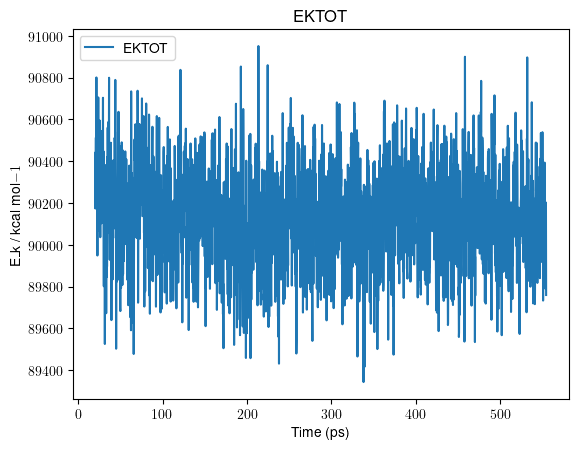

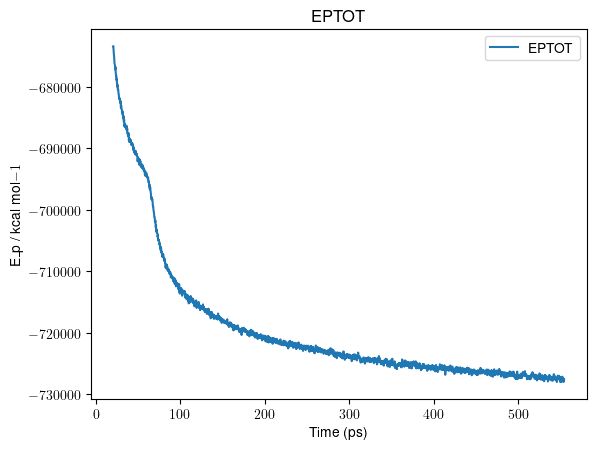

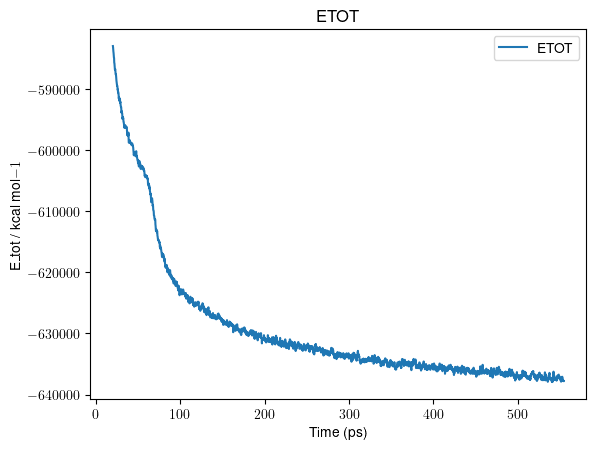

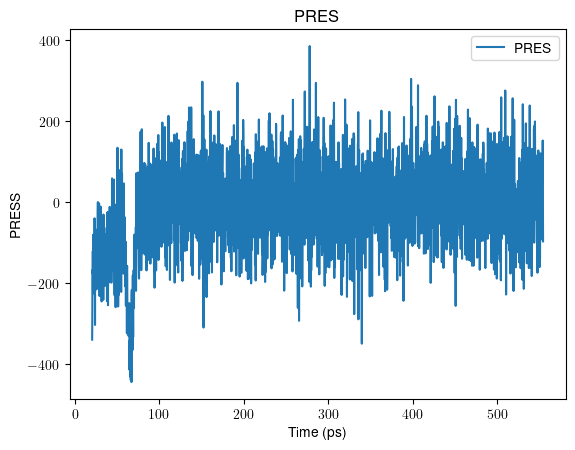

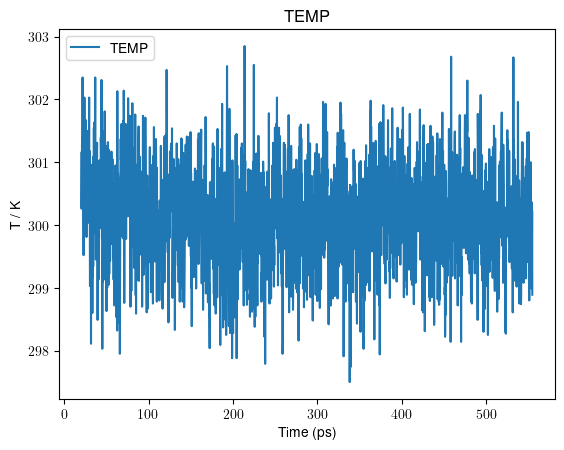

In [774]:
    # assign dataset names
    data = {'DENSITY':r'$\rho$',
            'EKCMT':r'E_k CMT / kcal mol$^-1$',
            'EKTOT':r'E_k / kcal mol$-1$',
            'EPTOT':r'E_p / kcal mol$-1$',
            'ESCF':r'ESCF',
            'ETOT':r'E_tot / kcal mol$-1$',
            'PRES':r'PRESS',
            'TEMP':r'T / K',
            'TSOLUTE':r'T / K',
            'TSOLVENT':r'T / K'}#,
    #        'VOLUME':r'V / $\AA^3$'}

    print(data)
    
    # create empty lists
    dataframes_list = []
    Ylabel_list = []
    Title_list = []

    # append datasets into the list
    for key, value in data.items():
        colnames=['Time (ps)',key]
        #print(colnames)
        temp_df = pd.read_csv("summary."+key,names=colnames,sep='\s+',index_col=None)
        if not temp_df.isnull().values.any():
            print(key,value)
            print(temp_df.head())
    # if temp_df.axes[1] == 1:

            dataframes_list.append(temp_df)
            temp_df.to_csv(dataframedir+name+key+'.csv',index=False)
            Ylabel_list.append(value)
            Title_list.append(key)

    for i in range(len(dataframes_list)):
        dataframes_list[i].plot(x=colnames[0],y=Title_list[i])
        plt.ylabel(Ylabel_list[i])
        plt.title(Title_list[i])
        plt.savefig('../text/figures/'+name+Title_list[i]+'.png')

In [775]:
###### Name of the system to be analyzed

#resultsdir = os.environ['SCRATCHDIR']  

run='md'
dataframedir = './data/'
name,resultsdir='dao_noNAG','/Volumes/BackFam/calculs/lavandula/'
generate_plots(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE5','/Volumes/BackFam/calculs/lapalma/'
generate_plots(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE25','/Volumes/BackFam/calculs/lapalma/'
generate_plots(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE100','/Volumes/BackFam/calculs/lapalma/'
generate_plots(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE250','/Volumes/BackFam/calculs/lapalma/'
generate_plots(name,run,resultsdir,dataframedir)

name,resultsdir='dao_noNAG_TRE500','/Volumes/BackFam/calculs/lapalma/'
generate_plots(name,run,resultsdir,dataframedir)

trajectory files: ['/Volumes/BackFam/calculs/lavandula/mddao_noNAG_1.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_2.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_3.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_4.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_5.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_6.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_7.nc', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_8.nc']
['/Volumes/BackFam/calculs/lavandula/mddao_noNAG_1.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_2.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_3.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_4.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_5.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_6.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_7.mdout', '/Volumes/BackFam/calculs/lavandula/mddao_noNAG_8.mdout']
trajectory files: ['/Volumes/BackFam/calculs/lapalma/mddao_noNAG_TRE5_1.nc',